In [1]:
%matplotlib inline

## Load SDSS sample

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


## Load $z=0$ baseline ${\rm UniverseMachine}$ mock with $M_{\ast}\ \&\ {\rm SFR}$

In [3]:
import os

#  MDPl2-based mock
# dirname = "/Users/aphearin/work/random/0330/testing_mock"
# basename = "sfr_catalog_1.000000_value_added.hdf5"
# fname = os.path.join(dirname, basename)

#  Bpl-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "testing_bpl_based_v4.hdf5"
fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')

#  Impute sSFR=0 values in the quenched sequence for plotting convenience
mock['obs_ssfr'] = mock['obs_sfr']/mock['obs_sm']
zero_mask = mock['obs_ssfr'] == 0
num_zeros = np.count_nonzero(zero_mask)
mock['obs_ssfr'][zero_mask] = 10**np.random.normal(loc=-13, scale=0.25, size=num_zeros)

print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile', 'obs_ssfr']


## Load ${\rm protoDC2\ v3}$ at $z=0$

In [4]:
dirname = "/Users/aphearin/Dropbox/protoDC2/umachine_z0p1_color_mock"
basename = "umachine_z0p1_color_mock.hdf5"
fname = os.path.join(dirname, basename)
from astropy.table import Table
v3_mock = Table.read(fname, path='data')
print(v3_mock.keys())

['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obs_sm', 'obs_sfr', 'mpeak', 'mvir', 'vmax', 'vmax_at_mpeak', 'upid', 'hostid', 'has_matching_host', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_ssfr', 'sfr_percentile_fixed_sm', 'rmag', 'sdss_petrosian_gr', 'sdss_petrosian_ri', 'size_kpc', 'dr7_photoobj_id']


##  Assign Absolute r-band magnitude

In [5]:
from cosmodc2.sdss_colors import median_magr_from_mstar

#  y_table=[-18.8, -20.1, -22.8]

median_magr = median_magr_from_mstar(np.log10(mock['obs_sm']))
mock['restframe_extincted_sdss_abs_magr'] = np.random.normal(
    loc=median_magr, scale=0.25, size=len(mock))

median_magr2 = median_magr_from_mstar(np.log10(mock['obs_sm']))
mock['rmag2'] = np.random.normal(
    loc=median_magr2, scale=0.15, size=len(mock))

median_magr3 = median_magr_from_mstar(np.log10(mock['obs_sm']),
                y_table=[-18.9, -20.2, -22.55])
mock['rmag3'] = np.random.normal(
    loc=median_magr3, scale=0.2, size=len(mock))



In [6]:
from cosmodc2.sdss_colors import dim_satellites

log_mhost = np.log10(mock['host_halo_mvir'])
log_mpeak = np.log10(mock['mpeak'])
upid = mock['upid']

mock['restframe_extincted_sdss_abs_magr'] = dim_satellites(
    mock['restframe_extincted_sdss_abs_magr'], log_mpeak, log_mhost, upid)
mock['rmag2'] = dim_satellites(mock['rmag2'], log_mpeak, log_mhost, upid)
mock['rmag3'] = dim_satellites(mock['rmag3'], log_mpeak, log_mhost, upid)

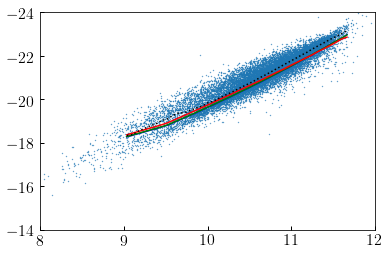

In [7]:
fig, ax = plt.subplots(1, 1)

nskip_sdss = 10
__=ax.scatter(sdss['sm'][::nskip_sdss], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip_sdss], s=0.1)

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 11.7, 40)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_magr_model1, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logsm_bins, statistic='median')
median_magr_model2, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['rmag2'], 
    bins=logsm_bins, statistic='median')
median_magr_model3, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['rmag3'], 
    bins=logsm_bins, statistic='median')

median_magr_v3, __, __ = binned_statistic(
    np.log10(v3_mock['obs_sm']), v3_mock['rmag'], 
    bins=logsm_bins, statistic='median')

nskip_mock = 50

__=ax.plot(logsm_mids, median_magr_model1, color='blue')
__=ax.plot(logsm_mids, median_magr_model2, color='green')
__=ax.plot(logsm_mids, median_magr_model3, color='red')

__=ax.plot(logsm_mids, median_magr_v3, ':', color='k')

ylim = ax.set_ylim(-19, -23.25)
xlim = ax.set_xlim(9.5, 11.5)

ylim = ax.set_ylim(-14, -24)
xlim = ax.set_xlim(8, 12)


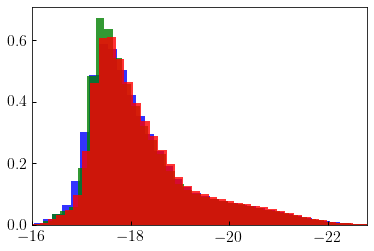

In [8]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(mock['restframe_extincted_sdss_abs_magr'], 
           bins=50, normed=True, alpha=0.8, color='blue')
__=ax.hist(mock['rmag2'], bins=50, normed=True, alpha=0.8, color='green')
__=ax.hist(mock['rmag3'], bins=50, normed=True, alpha=0.8, color='red')

xlim = ax.set_xlim(-16, -22.8)

## Compare cumulative number density to Zehavi+11

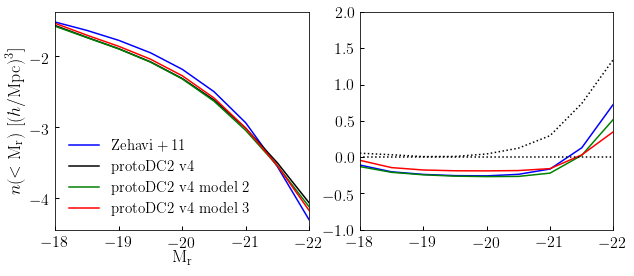

In [9]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = 250.**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4_model2 = cumulative_nd(mock['rmag2'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4_model3 = cumulative_nd(mock['rmag3'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
volume_v3 = 250.**3.
cumnd_pdc2_v3 = cumulative_nd(v3_mock['rmag'], 
                           volume_v3, protoDC2_littleh, lumthresh_h1p0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color='blue')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), 
            label=r'${\rm protoDC2\ v4}$', color='k')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4_model2), 
            label=r'${\rm protoDC2\ v4\ model\ 2}$', color='green')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4_model3), 
            label=r'${\rm protoDC2\ v4\ model\ 3}$', color='red')

fracdiff_pdc2_v4 = (cumnd_pdc2_v4 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4_model2 = (cumnd_pdc2_v4_model2 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4_model3 = (cumnd_pdc2_v4_model3 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v3 = (cumnd_pdc2_v3 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4, 
            label=r'${\rm protoDC2\ v4}$', color='blue')
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4_model2, 
            label=r'${\rm protoDC2\ v4\ model\ 2}$', color='green')
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4_model3, 
            label=r'${\rm protoDC2\ v4\ model\ 3}$', color='red')
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v3, ':', color='k', 
            label=r'${\rm protoDC2\ v3}$')
__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')

xlim1 = ax1.set_xlim(-18, -22)
ylim2 = ax2.set_ylim(-1, 2)

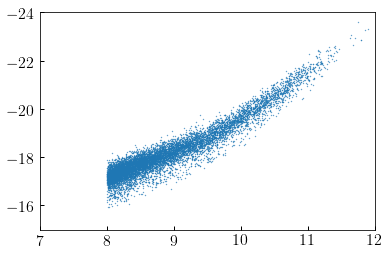

In [10]:
fig, ax = plt.subplots(1, 1)

nskip_sdss = 10
# __=ax.scatter(sdss['sm'][::nskip_sdss], 
#               sdss['restframe_extincted_sdss_abs_magr'][::nskip_sdss], s=0.1)

from scipy.stats import binned_statistic
logsm_bins = np.linspace(8, 11.7, 40)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_magr_model1, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logsm_bins, statistic='median')
median_magr_model2, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['rmag2'], 
    bins=logsm_bins, statistic='median')
median_magr_model3, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['rmag3'], 
    bins=logsm_bins, statistic='median')

nskip_mock = 50

# __=ax.plot(logsm_mids, median_magr_model1, color='k')
# __=ax.plot(logsm_mids, median_magr_model2, color='green')
# __=ax.plot(logsm_mids, median_magr_model3, color='red')

nskip = 200
__=ax.scatter(np.log10(mock['obs_sm'][::nskip]), 
              mock['restframe_extincted_sdss_abs_magr'][::nskip], s=0.1)


ylim = ax.set_ylim(-15, -24)
xlim = ax.set_xlim(7, 12)

## Compare luminosity threshold clustering to Zehavi+11

In [11]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = 250.
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_um_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_um_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_um_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_um_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 2.00e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.31e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...calculating wp for 3.79e+04 galaxies and Mr < -20.5
...calculating wp for 4.94e+03 galaxies and Mr < -21.5


In [12]:
x, y, z, vz = v3_mock['x'], v3_mock['y'], v3_mock['z'], v3_mock['vz']
magr = v3_mock['rmag']

rp_mids, wp_v3_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v3_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v3_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v3_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 2.64e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.77e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...calculating wp for 5.59e+04 galaxies and Mr < -20.5
...calculating wp for 7.62e+03 galaxies and Mr < -21.5


In [13]:
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['rmag2']

rp_mids, wp_um2_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_um2_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_um2_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_um2_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 1.98e+05
...calculating wp for 9.97e+04 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.29e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...calculating wp for 3.65e+04 galaxies and Mr < -20.5
...calculating wp for 4.49e+03 galaxies and Mr < -21.5


In [14]:
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['rmag3']

rp_mids, wp_um3_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_um3_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_um3_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_um3_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 2.16e+05
...calculating wp for 9.98e+04 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.42e+05
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...calculating wp for 4.05e+04 galaxies and Mr < -20.5
...calculating wp for 4.52e+03 galaxies and Mr < -21.5


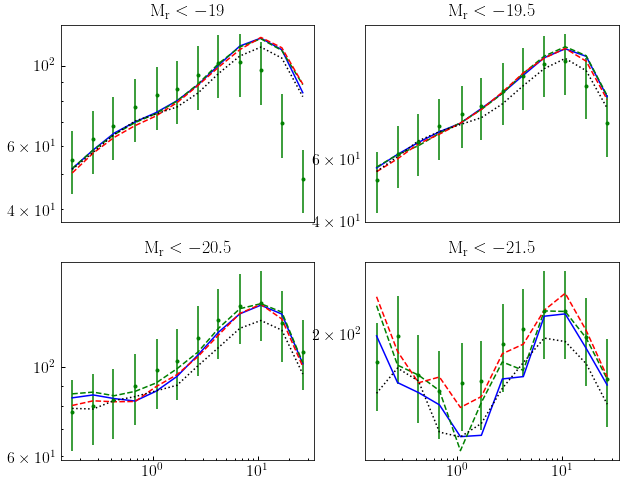

In [15]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

# __=ax.plot(rp_mids, rp_mids*wp_v3_20p5, '--', color='red')


__=ax1.plot(rp_mids, rp_mids*wp_um_19p0, color='blue')
__=ax1.plot(rp_mids, rp_mids*wp_um2_19p0, '--',  color='green')
__=ax1.plot(rp_mids, rp_mids*wp_um3_19p0, '--',  color='red')
__=ax1.plot(rp_mids, rp_mids*wp_v3_19p0, ':',  color='k')
__=ax1.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p0, rp_zehavi*0.2*wp_zehavi_19p0, 
               fmt='.', color='green')

__=ax2.plot(rp_mids, rp_mids*wp_um_19p5, color='blue')
__=ax2.plot(rp_mids, rp_mids*wp_um2_19p5, '--',  color='green')
__=ax2.plot(rp_mids, rp_mids*wp_um3_19p5, '--',  color='red')
__=ax2.plot(rp_mids, rp_mids*wp_v3_19p5, ':',  color='k')
__=ax2.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p5, rp_zehavi*0.2*wp_zehavi_19p5, 
               fmt='.', color='green')

__=ax3.plot(rp_mids, rp_mids*wp_um_20p5, color='blue')
__=ax3.plot(rp_mids, rp_mids*wp_um2_20p5, '--',  color='green')
__=ax3.plot(rp_mids, rp_mids*wp_um3_20p5, '--',  color='red')
__=ax3.plot(rp_mids, rp_mids*wp_v3_20p5, ':',  color='k')
__=ax3.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_20p5, rp_zehavi*0.2*wp_zehavi_20p5, 
               fmt='.', color='green')

__=ax4.plot(rp_mids, rp_mids*wp_um_21p5, color='blue')
__=ax4.plot(rp_mids, rp_mids*wp_um2_21p5, '--',  color='green')
__=ax4.plot(rp_mids, rp_mids*wp_um3_21p5, '--',  color='red')
__=ax4.plot(rp_mids, rp_mids*wp_v3_21p5, ':',  color='k')
__=ax4.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_21p5, rp_zehavi*0.2*wp_zehavi_21p5, 
               fmt='.', color='green')

title1 = ax1.set_title(r'${\rm M_{r} < -19}$')
title2 = ax2.set_title(r'${\rm M_{r} < -19.5}$')
title3 = ax3.set_title(r'${\rm M_{r} < -20.5}$')
title4 = ax4.set_title(r'${\rm M_{r} < -21.5}$')

__=ax1.xaxis.set_ticks_position('none') 
__=ax1.set_xticklabels([''])

__=ax2.xaxis.set_ticks_position('none') 
__=ax2.set_xticklabels([''])

__=ax2.yaxis.set_ticks_position('none') 
__=ax2.set_yticklabels([''])

__=ax4.yaxis.set_ticks_position('none') 
__=ax4.set_yticklabels([''])

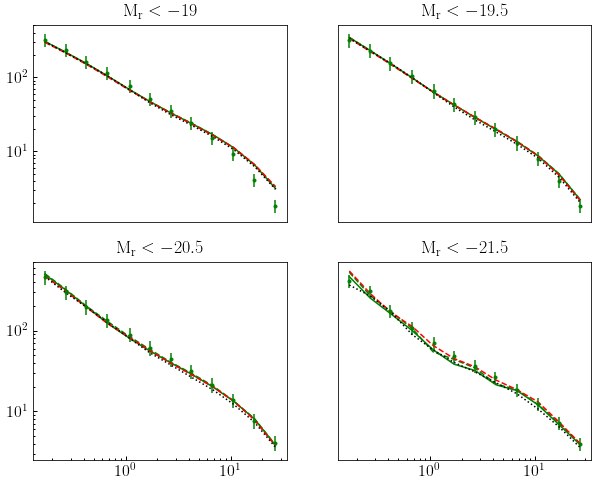

In [16]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

# __=ax.plot(rp_mids, rp_mids*wp_v3_20p5, '--', color='red')


__=ax1.plot(rp_mids, wp_um_19p0, color='green')
__=ax1.plot(rp_mids, wp_um2_19p0, '--',  color='green')
__=ax1.plot(rp_mids, wp_um3_19p0, '--',  color='red')
__=ax1.plot(rp_mids, wp_v3_19p0, ':',  color='k')
__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='green')

__=ax2.plot(rp_mids, wp_um_19p5, color='green')
__=ax2.plot(rp_mids, wp_um2_19p5, '--',  color='green')
__=ax2.plot(rp_mids, wp_um3_19p5, '--',  color='red')
__=ax2.plot(rp_mids, wp_v3_19p5, ':',  color='k')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='green')

__=ax3.plot(rp_mids, wp_um_20p5, color='green')
__=ax3.plot(rp_mids, wp_um2_20p5, '--',  color='green')
__=ax3.plot(rp_mids, wp_um3_20p5, '--',  color='red')
__=ax3.plot(rp_mids, wp_v3_20p5, ':',  color='k')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='green')

__=ax4.plot(rp_mids, wp_um_21p5, color='green')
__=ax4.plot(rp_mids, wp_um2_21p5, '--',  color='green')
__=ax4.plot(rp_mids, wp_um3_21p5, '--',  color='red')
__=ax4.plot(rp_mids, wp_v3_21p5, ':',  color='k')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='green')

title1 = ax1.set_title(r'${\rm M_{r} < -19}$')
title2 = ax2.set_title(r'${\rm M_{r} < -19.5}$')
title3 = ax3.set_title(r'${\rm M_{r} < -20.5}$')
title4 = ax4.set_title(r'${\rm M_{r} < -21.5}$')

__=ax1.xaxis.set_ticks_position('none') 
__=ax1.set_xticklabels([''])

__=ax2.xaxis.set_ticks_position('none') 
__=ax2.set_xticklabels([''])

__=ax2.yaxis.set_ticks_position('none') 
__=ax2.set_yticklabels([''])

__=ax4.yaxis.set_ticks_position('none') 
__=ax4.set_yticklabels([''])

In [17]:
# wp_um_19p0 = wp(um_pos_19p0, rp_bins, pi_max, period=250, num_threads='max')
# wp_um_20p0 = wp(um_pos_20p0, rp_bins, pi_max, period=250, num_threads='max')
# wp_um_21p0 = wp(um_pos_21p0, rp_bins, pi_max, period=250, num_threads='max')
# wp_um_21p5 = wp(um_pos_21p5, rp_bins, pi_max, period=250, num_threads='max')

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile', 'obs_ssfr', 'restframe_extincted_sdss_abs_magr', 'rmag2', 'rmag3']


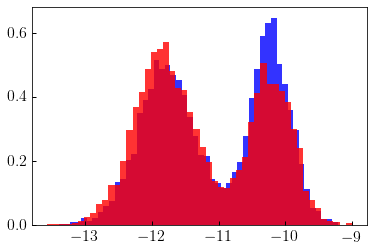

In [18]:
print(mock.keys())

satmask = mock['upid'] != -1
cluster_mask = mock['host_halo_mvir'] > 10**14
mw_mask = (mock['host_halo_mvir'] > 10**11.75) & (mock['host_halo_mvir'] < 10**12.5)
sm_mask = (mock['obs_sm'] > 10**10) & (mock['obs_sm'] < 10**10.25)


fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(mock['obs_ssfr'][satmask & mw_mask & sm_mask]), bins=50, normed=True,
          alpha=0.8, color='blue')
__=ax.hist(np.log10(mock['obs_ssfr'][satmask & cluster_mask & sm_mask]), bins=50, normed=True,
          alpha=0.8, color='red')